<a href="https://colab.research.google.com/github/xysu129/deep-learning-ust-2026/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6 — Autoencoder on MNIST Digits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE

## 1. Dataset Overview

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0, 1] and flatten to 784-dim vectors
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_flat = x_train.reshape(-1, 784)
x_test_flat = x_test.reshape(-1, 784)

print(f"Training set: {x_train_flat.shape[0]} samples, {x_train_flat.shape[1]} features")
print(f"Test set:     {x_test_flat.shape[0]} samples, {x_test_flat.shape[1]} features")
print(f"Classes:      {np.unique(y_train)} (10 digit classes)")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: 60000 samples, 784 features
Test set:     10000 samples, 784 features
Classes:      [0 1 2 3 4 5 6 7 8 9] (10 digit classes)


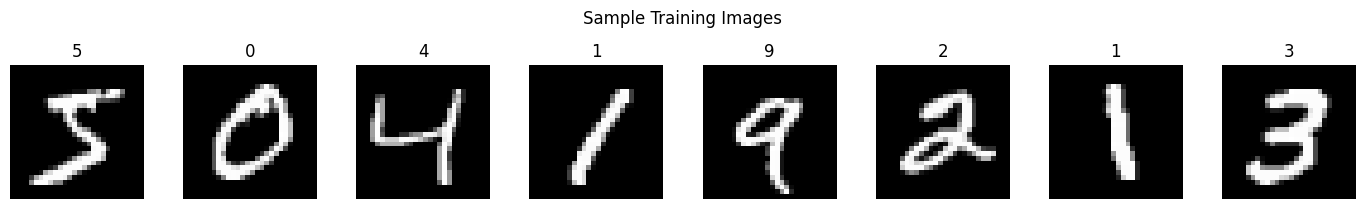

In [3]:
# Preview training examples
fig, axes = plt.subplots(1, 8, figsize=(14, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))
    ax.axis('off')
plt.suptitle("Sample Training Images", y=1.02)
plt.tight_layout()
plt.show()

## 2. Autoencoder Architecture

A symmetric 3-layer encoder/decoder with a 16-dimensional bottleneck (49x compression).

```
Encoder:  784 → 256 → 64 → 16
Decoder:  16 → 64 → 256 → 784
```

In [4]:
# Encoder
input_layer = Input(shape=(784,))
x = Dense(256, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
bottleneck = Dense(16, activation='relu', name='bottleneck')(x)

# Decoder
x = Dense(64, activation='relu')(bottleneck)
x = Dense(256, activation='relu')(x)
output_layer = Dense(784, activation='sigmoid')(x)

# Full autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Encoder model for extracting latent codes
encoder = Model(input_layer, bottleneck)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,664 (1.67 MB)

 Trainable params: 437,664 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training

In [5]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history = autoencoder.fit(
    x_train_flat, x_train_flat,
    epochs=80,
    batch_size=512,
    validation_split=0.15,
    callbacks=callbacks
)

Epoch 1/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.4004 - val_loss: 0.2094 - learning_rate: 0.0010
Epoch 2/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1941 - val_loss: 0.1628 - learning_rate: 0.0010
Epoch 3/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1575 - val_loss: 0.1437 - learning_rate: 0.0010
Epoch 4/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1413 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 5/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1324 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 6/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1264 - val_loss: 0.1220 - learning_rate: 0.0010
Epoch 7/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1212 - val_loss: 0.1184 - learning_rate: 0.0010
Epoch 8/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1175 - val_loss: 0.1158 - learning_rate: 0.0010
Epoch 9/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1148 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 10/

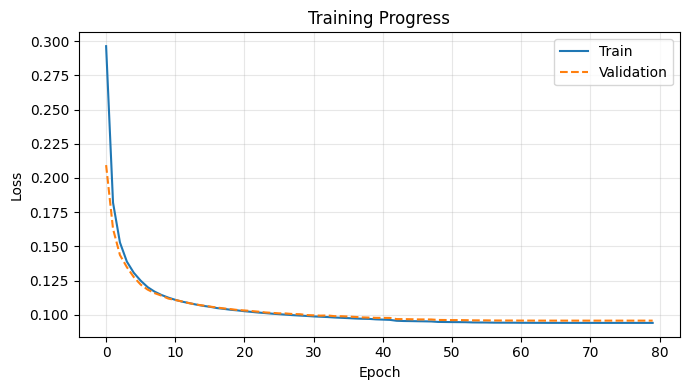

In [6]:
# Loss curves
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Embedding Space Visualization

Extract 16-dim latent codes from the encoder, then project to 2D with t-SNE.

In [7]:
# Get latent representations
embeddings = encoder.predict(x_test_flat)
print(f"Latent code shape: {embeddings.shape}")

# t-SNE (may take 1-2 minutes)
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=40, random_state=0, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Latent code shape: (10000, 16)
Running t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


/tmp/ipython-input-564771050.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Spectral', 10)


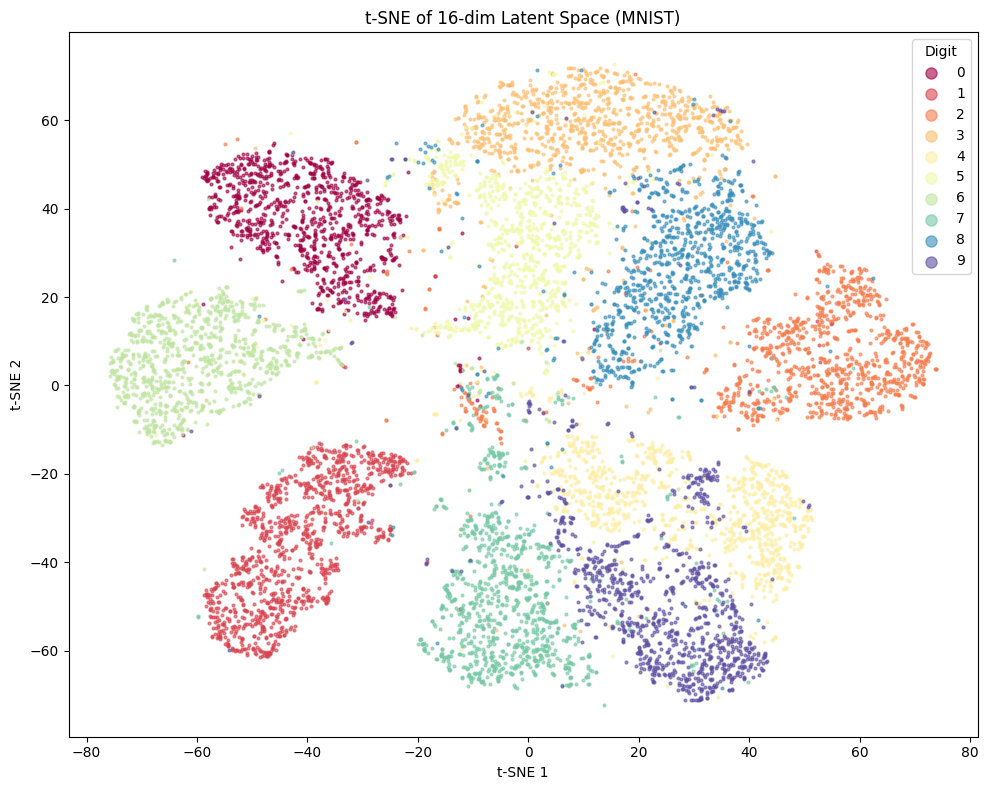

In [8]:
# Plot each digit class separately for a clean legend
cmap = plt.cm.get_cmap('Spectral', 10)

plt.figure(figsize=(10, 8))
for digit in range(10):
    mask = y_test == digit
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                c=[cmap(digit)], label=str(digit), s=4, alpha=0.6)

plt.legend(markerscale=4, title='Digit')
plt.title('t-SNE of 16-dim Latent Space (MNIST)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

## 5. Reconstruction Quality

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


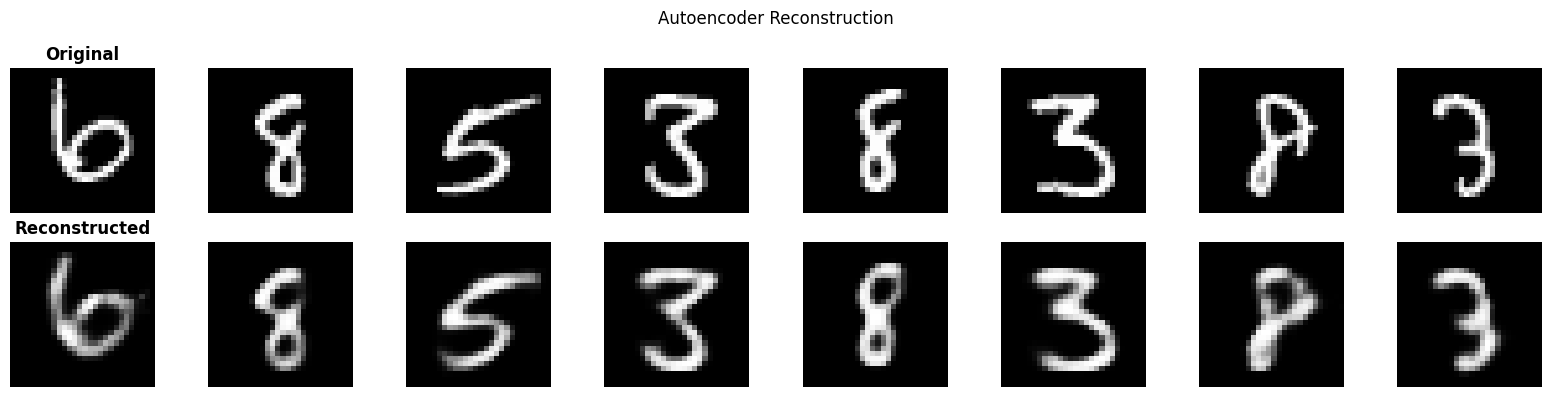

In [9]:
# Randomly select test samples
np.random.seed(7)
idx = np.random.choice(len(x_test), 8, replace=False)
originals = x_test_flat[idx]
reconstructed = autoencoder.predict(originals)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(originals[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title('Original', fontweight='bold')

    axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title('Reconstructed', fontweight='bold')

plt.suptitle('Autoencoder Reconstruction')
plt.tight_layout()
plt.show()

## Observations

**Dataset:** 70,000 grayscale images (28×28 = 784 features), 10 digit classes.

**Network:** 784 → 256 → 64 → **16** → 64 → 256 → 784, trained with binary cross-entropy and Adam.

**Embedding space findings:**
- The t-SNE plot shows clear separation of digit clusters, confirming the 16-dim bottleneck preserves class identity.
- Digits with similar stroke patterns (e.g., 4/9, 3/5/8, 7/1) tend to sit closer together — the autoencoder captures visual similarity.
- Reconstruction quality is good — digits are recognizable even with 49x compression (784 → 16).